# Test of Gym Environment Functions

In [1]:
import time
import math
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

## 1. Generate random world size

In [2]:
def varyWorldSize():
    shapes=(20, 64)
    shapes = np.random.randint(shapes[0], shapes[1] + 1)
    shape = (shapes, shapes)
    return shape

In [3]:
for i in range(10):
    print(varyWorldSize())

(22, 22)
(33, 33)
(58, 58)
(42, 42)
(27, 27)
(39, 39)
(45, 45)
(46, 46)
(46, 46)
(22, 22)


Conclusion: 
This function generates a random world size between 20x20 and 64x64 (or whatever the values of `shapes` are)

## 2. Generate Gaussian bivariate distribution

Bivariate distribution formula:

$c = \frac{1}{2\pi\sigma_x\sigma_y\sqrt{1-r^2}} \cdot e^{-\frac{1}{2(1-r^2)} \left(\frac{(x-\mu_x)^2}{\sigma^2_x} - \frac{2r(x-\mu_x)(y-\mu_y)}{\sigma_x\sigma_y} + \frac{(y-\mu_y)^2}{\sigma^2_y} \right)}$

In [4]:
def bivariateGaussianMatrix(variance):
    """
    Generates a single (not mixture) bivariate normal distribution, with independent axes
    Input:
        - variance: scales a the random variance for the x and y components
    Output:
        - distribution_matrix: 2D array containing single normal bivariate distribution
    Note:
        - map_shape needs to be declared before
    """
    
    # Generate means and covariance matrices
    gaussian_mean = map_shape[0] * np.random.rand(1, 2)[0] # This generates a number 0-20 randomly
    gaussian_var = np.zeros((2, 2)) 
    gaussian_var[([0, 1], [0, 1])] = variance * np.random.rand(1, 2)[0] # Generates a random covariance matrix scaled by variance
    SigmaX = np.sqrt(gaussian_var[0][0])
    SigmaY = np.sqrt(gaussian_var[1][1])
    Covariance = gaussian_var[0][1]
    
    r = Covariance / (SigmaX * SigmaY) # Pearson correlation
    
    row_mat, col_mat = np.meshgrid(np.linspace(0, map_shape[0] - 1, map_shape[0]),
                                   np.linspace(0, map_shape[1] - 1, map_shape[1]))
    
    coefficients = 1 / (2 * math.pi * SigmaX * SigmaY * np.sqrt(1 - math.pow(r, 2))) # Not sure what this is
    p1 = -1 / (2 * (1 - math.pow(r, 2)))
    px = np.power(row_mat - gaussian_mean[0], 2) / gaussian_var[0][0]
    py = np.power(col_mat - gaussian_mean[1], 2) / gaussian_var[1][1]
    pxy = 2 * r * (row_mat - gaussian_mean[0]) * (col_mat - gaussian_mean[1]) / (SigmaX * SigmaY)
    distribution_matrix = coefficients * np.exp(p1 * (px - pxy + py))

    return distribution_matrix

## 3. Create Uncertainty

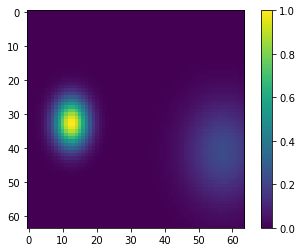

In [16]:
map_shape = (64,64)
variance_Scale = 100

def createUncertainty():
        """
        create the uncertainty of the map, and this map is used to set the targets
        """
        numDistribs = 2 #np.random.randint(self.rangeDistribs[0], self.rangeDistribs[1] + 1)
        uncertaintyMap = np.array([bivariateGaussianMatrix(map_shape, variance_scale) for _ in range(numDistribs)])
        uncertaintyMap = np.mean(uncertaintyMap, axis=0)
        uncertaintyMap /= np.sum(uncertaintyMap)
        uncertaintyMap /= np.max(uncertaintyMap)

        return uncertaintyMap
    
uncertainty = createUncertainty()
plt.imshow(uncertainty)
plt.colorbar()
plt.show()

# Why do we need an uncertainty map?

# Gym environment

In [398]:
import time
import math
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.spatial import Voronoi, voronoi_plot_2d 

np.random.seed(10)

# Define agent and environment settings (this will go in a class)
# ---------------------------------------------------------------------------------
map_shape = (64,64) # Top left: (0,0), Top right: (64, 0), Bottom right: (64,64)
variance_scale = 100
numDistribs = 2
annealing = 10000
epsilon = 0.1
curr_timestep = 0

# Convention for "active" map:
# 0: Not active
# 1: Active

# Convention for render map:
# 0: Not active
# 1: Active
# 2: Generator points
# 3: Cutting line
# 4: Region 1
# 5: Region 2
# ... (if needed)

# ---------------------------------------------------------------------------------


# Define all helper functions (these will go in a class)
# ---------------------------------------------------------------------------------

def bivariateGaussianMatrix(map_shape, variance_scale):
    """
    Generates a single (not mixture) bivariate normal distribution, with independent axes
    Input:
        - map_shape: tuple (x, y) representing the map size
        - variance_scale: scales a the random variance for the x and y components
    Output:
        - distribution_matrix: 2D array containing single normal bivariate distribution
        - mean of the bivariateGaussain
    """
    x, y = np.mgrid[0:map_shape[0], 0: map_shape[1]]
    pos = np.dstack((x, y))
    mean2D = map_shape[0] * np.random.rand(1, 2)[0]
    cov2D = np.zeros((2, 2)) 
    cov2D[([0, 1], [0, 1])] = variance_scale * np.random.rand(1, 2)[0]
    rv = multivariate_normal(mean2D, cov2D)
    return rv.pdf(pos), mean2D

def createInformationMap(numDistribs, map_shape, variance_scale):
    '''
    Generate a mixture of Gaussians, scaled so that the maximum value is close to 1.
    Input:
        - numDistribs: Number of distributions in the information map -> number of knots
        - map_shape: Shape of the map
        - variance_scale: Scaling value for the bivariateGaussianMatrix function
    Output:
        - infoMap: Mixture of Gaussians, plus a baseline probability for the rest of the cells
        - scalar: Scaling factor used to make maximum value = 1
        - means: Returns locations of the means of the distributions that make up the infoMap
    '''
    # Generate multiple bivariate Gaussians
    infoMaps = []
    means = []
    for _ in range(numDistribs):
        infoMap, meanDist = bivariateGaussianMatrix(map_shape, variance_scale)
        infoMaps.append(infoMap)
        means.append(meanDist)
    infoMaps = np.asarray(infoMaps)
    means = np.asarray(means)
    
    
    # Mixture of Gaussians + epsilon probability for "empty" space
    baseline = 0.1
    infoMap = (1 - baseline) * np.mean(infoMaps, axis=0) + baseline * np.ones(map_shape) / (
            map_shape[0] * map_shape[1])

    # Scale so that the maximum value in the map is 1
    # infoMapRaw = infoMap -> This is to check the actual values without scaling
    maxInfo = np.max(infoMap)
    scalar = 0.5/maxInfo * np.random.rand() + 0.5/maxInfo
    infoMap = infoMap * scalar
    
    return infoMap, scalar, means

def plot2D(array):
    '''
    Plot a 2D array with a colorbar
    Input:
        - array: 2D array to plot
    '''
    plt.imshow(array)
    plt.colorbar()
    plt.show()
    
    
def makeAndPlotVoronoi(sites, plot=True, colorize=False):
    '''
    Generate a Voronoi diagram out of an array of seeds (sites, points, etc)
    Input:
        - sites: Array of sites for the Voronoi diagram
        - plot: Boolean to plot the Voronoi diagram or not
        - colorize: Boolean to colorize the Voronoi diagram when plotting or not
    Output:
        - vor: Voronoi object
    '''
    vor = Voronoi(sites)
    
    if plot:
        voronoi_plot_2d(vor)
        if colorize:
            for region in vor.regions:
                if not -1 in region:
                    polygon = [vor.vertices[i] for i in region]
                    plt.fill(*zip(*polygon))
        plt.xlim([0,64]), plt.ylim([0,64])
        plt.show()
    return vor

def midPoint_and_slope(p1, p2):
    '''
    Finds the midpoint between two points and the slope of the perpendicular bisector
    
    Input:
        - p1: Tuple of point 1: (x,y)
        - p2: Tuple of point 2: (x,y)
    Output:
        - midPoint: Tuple (x,y)
        - slope: Float
    '''
    midPoint = ((p1[0]+ p2[0])/2, (p1[1] + p2[1])/2)
    
    slope_og = (p2[1] - p1[1])/(p2[0] - p1[0])
    
    slope = - 1/slope_og
    
    return midPoint, slope

def findEndpoints(midpoint, perpSlope, map_shape):
    '''
    This function finds the endpoints for a line that has a given midpoint and a slope. 
    
    Its intended use is in the case where we have two generator points, and we want to find the 
    cutting line between the two. To do this, we find the midpoint of these points, and the slope of the 
    perpendicular bisector.
    
    This is a naive approach, an improved version could be obtained by doing an incremental Bresenham's line algorithm
    starting at the point in both directions. In this approach, we find each of the four possible endpoints given our map
    dimensions, and we choose the two that lie within the boundary.
    
    Input:
        - midpoint: a tuple (x,y) representing a point in the line we want to find
        - perpSlope: a float representing the slope of the perpendicular bisector of two points
        - map_shape: a tuple (x,y) representing the size of the map
    Output:
        - endpoints: A list containing 2 integer tuples that represent the endpoints on the map: [(x_1, y_1), (x_2, y_2)]
    '''
    endpoints = []
    raw_endpoints = []
    
    # Check if slope is inf, -inf -> vertical cutting line
    if (perpSlope == -np.inf) or (perpSlope == np.inf):
#         print("slope is inf")
        endpoints.append((int(midpoint[0]), 0))
        endpoints.append((int(midpoint[0]), map_shape[1]-1))
        raw_endpoints.append((int(midpoint[0]), 0))
        raw_endpoints.append((int(midpoint[0]), map_shape[1]-1))
        return endpoints, raw_endpoints
    
    # Check if slope is 0, -0 -> horizontal cutting line
    if perpSlope == 0:
#         print("slope is 0")
        endpoints.append((0, int(midpoint[1])))
        endpoints.append((map_shape[0]-1, int(midpoint[1])))
        raw_endpoints.append((0, int(midpoint[1])))
        raw_endpoints.append((map_shape[0]-1, int(midpoint[1])))
        return endpoints, raw_endpoints
    
    # First possible endpoint: (x, 0)
    x_try = midpoint[0] - midpoint[1]/perpSlope
    
    if (int(round(x_try)) >= 0) and (int(round(x_try)) < map_shape[0]):
        if x_try >= 0:
            endpoints.append((int(round(x_try)), 0))
    raw_endpoints.append((x_try, 0))
    
    # Second possible endpoint: (x_map, y)
    y_try = (map_shape[0]-1) * perpSlope - perpSlope*midpoint[0] + midpoint[1] # mapshape-1 is to deal with indices starting at 0
    if (int(round(y_try)) >= 0) and (int(round(y_try)) < map_shape[1]):
        if y_try >= 0:
            endpoints.append((map_shape[0]-1, int(round(y_try))))
    raw_endpoints.append((map_shape[0]-1, y_try))
    
    # Third possible endpoint: (x, y_map)
    x_try = ((map_shape[1]-1) - midpoint[1] + perpSlope * midpoint[0]) / perpSlope
    if (int(round(x_try)) >= 0) and (int(round(x_try)) < map_shape[0]):
        if x_try >= 0:
            endpoints.append((int(round(x_try)), map_shape[1]-1))
    raw_endpoints.append((x_try, map_shape[1]-1))
    
    # Fourth possible endpoint: (0, y)
    y_try = -perpSlope * midpoint[0] + midpoint[1]
    if (int(round(y_try)) >= 0) and (int(round(y_try)) < map_shape[1]):
        if y_try >= 0:
            endpoints.append((0, int(round(y_try))))
    raw_endpoints.append((0, y_try))
    
    endpoints = list(set(endpoints)) # Accounts for corner coordinates
    
    if len(endpoints) != 2:
        print("ERROR: Don't have two endpoints!")
        
    return endpoints, raw_endpoints

def drawLine(start, end):
    '''
    Implements Bresenham's line algorithm
    From http://www.roguebasin.com/index.php?title=Bresenham%27s_Line_Algorithm
    
    Input:
        - start: Tuple of coordinates for starting point (x,y)
        - end: Tuple of coordinates for end point (x,y)
    Output:
        - points: List of points that make up the line between the start and end points
    '''
    # Setup initial conditions
    x1, y1 = start
    x2, y2 = end
    dx = x2 - x1
    dy = y2 - y1
 
    # Determine how steep the line is
    is_steep = abs(dy) > abs(dx)
 
    # Rotate line
    if is_steep:
        x1, y1 = y1, x1
        x2, y2 = y2, x2
 
    # Swap start and end points if necessary and store swap state
    swapped = False
    if x1 > x2:
        x1, x2 = x2, x1
        y1, y2 = y2, y1
        swapped = True
 
    # Recalculate differentials
    dx = x2 - x1
    dy = y2 - y1
 
    # Calculate error
    error = int(dx / 2.0)
    ystep = 1 if y1 < y2 else -1
 
    # Iterate over bounding box generating points between start and end
    y = y1
    points = []
    for x in range(x1, x2 + 1):
        coord = (y, x) if is_steep else (x, y)
        points.append(coord)
        error -= abs(dy)
        if error < 0:
            y += ystep
            error += dx
 
    # Reverse the list if the coordinates were swapped
    if swapped:
        points.reverse()
    return points

def drawMultipleLines(ridgeVertices):
    '''
    Calls the drawLine method for each pair of vertices in the array ridgeVertices
    Input:
        - ridgeVertices: 3D array (n, 2, 2) where n is the number of ridges to draw,
                         the second dimension represents the two endpoints of the line, 
                         and the third dimension represents the x,y coordinates for a point
    Outpu:
        - lines: A list of lists, where each of the lists is the coordinates of the points
                 that make up each line
    
    '''
    
    lines = []
    for n in range(ridgeVertices.shape[0]):
        v1 = tuple(ridgeVertices[n][0])
        v2 = tuple(ridgeVertices[n][1])
        
        # Make the vertices integers instead of floats
        v1 = tuple(map(int, v1))
        v2 = tuple(map(int, v2))
        lines.append(drawLine(v1, v2))
    return lines

# ---------------------------------------------------------------------------------

In [24]:
# Create Ground Truth Information Map:
# Create a Gaussian Mixture Model with 2 distributions, 64x64 map, and save it
infoMap, scalar, means = createInformationMap(numDistribs, map_shape, variance_scale)
# Create active array w ones((64,64)) representing active areas, where knots will be chosen 
active = np.zeros(map_shape)
# Create render map for visualization purposes
renderMap = np.zeros(map_shape)

In [25]:
# Create agent's belief:
# Create initial distribution: 1/64*64
belief = np.ones(map_shape) / (map_shape[0] * map_shape[1])

# Create uncertainty distribution: 1 everywhere
uncertainty = np.ones(map_shape)

Epsilon: 1.0
Exploring


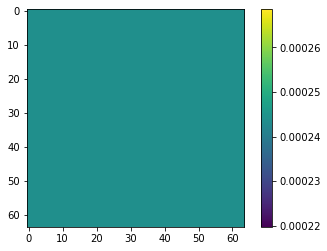

(36, 51)
(16, 36)


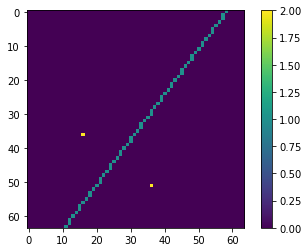

In [26]:
# Create actions:
# Choose 2 points: choose random w prob ~1, linearly decrease to choose max 2 vals in agent's belief
curr_epsilon = np.maximum(((epsilon - 1) / annealing) * curr_timestep + 1, epsilon) # exploration rate (epsilon) at the current timestep

random_sample = np.random.rand()
print("Epsilon: " + str(curr_epsilon))
if curr_epsilon > random_sample:
    # Explore! Choose two random integer pairs
    print("Exploring")
    p1 = (np.random.randint(0,map_shape[0]-1), np.random.randint(0,map_shape[1]-1))
    p2 = (np.random.randint(0,map_shape[0]-1), np.random.randint(0,map_shape[1]-1))
    
else:
    # Choose the two highest points in the array for now -> Later: Output of a neural net
    
    first_peak_val = np.partition(belief.flatten(), -2)[-1]
    first_peak_index = tuple(np.argwhere(belief==first_peak_val)[0])
    second_peak_val = np.partition(belief.flatten(), -2)[-2]
    second_peak_index = tuple(np.argwhere(belief==second_peak_val)[0])
    
    # Validate peaks: (This could be extended to have at least one space in between peaks if necessary)
    count = 0
    if first_peak_index == second_peak_index:
        count += 1
        second_peak_index = tuple(np.argwhere(belief==second_peak_val)[count])
    
    p1 = first_peak_index
    p2 = second_peak_index
    
plot2D(belief)
print(p1)
print(p2)

active[p1[::-1]] = 2
active[p2[::-1]] = 2

# Find endpoints of the cuts based on these points: 2-point Voronoi diagram

midpoint, slope = midPoint_and_slope(p1, p2)
endpoints, raw_endpoints = findEndpoints(midpoint, slope, map_shape)
endp1 = endpoints[0]
endp2 = endpoints[1]

# Draw Bresenham's line: 
# Assume endpoints has two elements
# We need to reverse the order of the points for plotting purposes. See convention above

points = drawLine(endp1[::-1],endp2[::-1])
for i in points:
    active[i] = 1
plot2D(active)

# Cut: Go through each of the spaces in the cutting line if possible, count the effort it takes, update the agent's 
# belief and uncertainty at each point (Need sensor). Return success/not success + amount of work done


# "Analyze cut": Determine if a cut was valid, and if so, if the separated regions are < certain area -> How do we 
# separate the regions? Everything below and to the left is a color until you find a 1, everything above 
# and to the right is another color until you find a 1? Return a quantifiable success metric for the reward


# Update map: Clean up "collected" areas

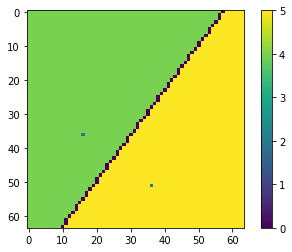

In [27]:
'''
If cut is sucessful we seperate the regions to identify whether it can be collected or not 
'''

for k in range(len(points)):
#     print(points[k])
    i = points[k][0]
    for j in range(points[k][1]-1):
        active[i][j] = 4
    for j in range(64-points[k][1]):
        active[i][-j-1] = 5
active[p1[::-1]] = 2
active[p2[::-1]] = 2
plot2D(active)

In [28]:
# Calculate reward


In [29]:
# Determine if episode is over or not



In [30]:
#Calculate area and determine if it is small enough to collect or not
threshold = 2000
value = [4,5]
print(value)
for i in value:
    occurrences = np.count_nonzero(active == i)
    print(occurrences)
    if occurrences<=threshold:
        print('Region with value {} is small enough to be picked up' .format(i))

[4, 5]
2143
1887
Region with value 5 is small enough to be picked up


### Testbed for Voronoi diagrams

In [31]:
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d 
import matplotlib.pyplot as plt

In [32]:
sites = np.random.randint(0, 63, (15,2))

In [33]:
sites

array([[47, 11],
       [54, 24],
       [43, 58],
       [62, 33],
       [ 8, 36],
       [14, 49],
       [51, 54],
       [13,  5],
       [13, 51],
       [25, 62],
       [13, 28],
       [22, 30],
       [30, 25],
       [12,  1],
       [31, 57]])

In [34]:
sites_flipped = []
for s in sites.tolist():
    sites_flipped.append(s[::-1])
sites_flipped = np.asarray(sites_flipped)

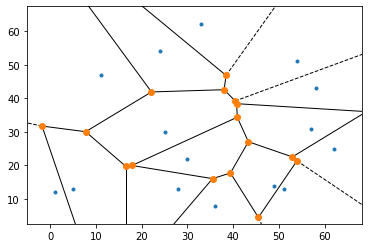

In [35]:
vor = Voronoi(sites)
# voronoi_plot_2d(vor)
# plt.show()

vor_flipped = Voronoi(sites_flipped)
voronoi_plot_2d(vor_flipped)
plt.show()

In [36]:
def voronoi_finite_polygons_2d(vor, radius=None):
    """Reconstruct infinite Voronoi regions in a
    2D diagram to finite regions.
    Source:
    [https://stackoverflow.com/a/20678647/1595060](https://stackoverflow.com/a/20678647/1595060)
    """
    print("Running voronoi_finite_polygons_2d")
    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")
    new_regions = []
    new_vertices = vor.vertices.tolist()
    new_ridge_vertices = []
    vor_ridge_vertices = vor.ridge_vertices
    for p in vor_ridge_vertices:
        if all(i >= 0 for i in p):
            new_ridge_vertices.append(p)
#     print("===================")
#     print("Starting state: ")
#     print("new_regions: ")
#     print(new_regions)
#     print("new_vertices: ")
#     print(new_vertices)
    center = vor.points.mean(axis=0)
#     print("center: " + str(center))
    if radius is None:
        radius = vor.points.ptp().max()
#     print("radius: " + str(radius))
    # Construct a map containing all ridges for a
    # given point
#     print("====================")
    
#     print("====================")
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points,
                                  vor.ridge_vertices):
        all_ridges.setdefault(
            p1, []).append((p2, v1, v2))
        all_ridges.setdefault(
            p2, []).append((p1, v1, v2))
#     print("all_ridges: ")
#     print(all_ridges)
#     print("====================")

#     print("--------------------")
    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region): # p1 is a counter (0,1, etc), region is the region "name (label)" for the p1th point
#         print("++++++++++++++++++++")
#         print("Examining p1: " + str(p1) + ", region: " + str(region))
        vertices = vor.regions[region] # Returns the vertices that corresponds to the "region_th" region. Region starts at 1
#         print("Vertices for this region: " + str(vertices))
        if all(v >= 0 for v in vertices):
            # finite region
#             print("All v >= 0, finite region, append to new_regions!")
            new_regions.append(vertices)
#             print("new_regions: ")
#             print(new_regions)
#             print("Continue!")
            continue
        # reconstruct a non-finite region
#         print("ridges for p1: (" + str(p1) + ")")
        ridges = all_ridges[p1] # Get a list of all ridges surrounding that point [(p2, v1, v2)]
#         print(ridges)
        new_region = [v for v in vertices if v >= 0] # new_region contains all the finite vertices from std vor
#         print("New_region: contains all finite vertices for region " + str(region))
#         print(new_region)
        for p2, v1, v2 in ridges:
#             print("====================")
#             print("Current ridge: (p1, p2, v1, v2)")
#             print("(" + str(p1) + ", " + str(p2) + ", " + str(v1) + ", " + str(v2) + ")")
            if v2 < 0: # Why is this here? Just to flip order?
                v1, v2 = v2, v1
            if v1 >= 0:  # v1 is always the one that could be at infinity
                # finite ridge: already in the region
#                 print("Neither vertices are infinite!")
#                 print("Continue!")
                continue
#             print("Current ridge updated: (p1, p2, v1, v2)")
#             print("(" + str(p1) + ", " + str(p2) + ", " + str(v1) + ", " + str(v2) + ")")
            # Compute the missing endpoint of an
            # infinite ridge
            t = vor.points[p2] - \
                vor.points[p1]  # tangent
            t /= np.linalg.norm(t) # Normalize
            n = np.array([-t[1], t[0]])  # normal
            midpoint = vor.points[[p1, p2]]. \
                mean(axis=0)
            direction = np.sign(
                np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + \
                direction * radius
#             print("far_point: " + str(far_point)) 
            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())
#             print("Updated new_region and new_vertices:")
#             print("new_region: " + str(new_region))
#             print("new_vertices: " + str(new_vertices))
            
#             print("Appending new ridge_vertices: ")
            new_ridge_vertices.append([v2, len(new_vertices)-1])
#             print("new_ridge_vertices: ")
#             print(new_ridge_vertices)
#             print("====================")
        # Sort region counterclockwise.
        vs = np.asarray([new_vertices[v]
                         for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(
            vs[:, 1] - c[1], vs[:, 0] - c[0])
        new_region = np.array(new_region)[
            np.argsort(angles)]
#         print("sorted new_region: " + str(new_region))
        new_regions.append(new_region.tolist())
#         print("Updated new_regions: " + str(new_regions))
#         print("++++++++++++++++++++")
    
#     print("--------------------")
    return new_regions, np.asarray(new_vertices), new_ridge_vertices


def vertIdxToVal(vertices, ridge_vertices):
    '''
    Transforms the array of *indices* ridge_vertices into actual locations
    Input:
        vertices: Array containing the locations of all vertices
        ridge_Vertices: Array of indices (to vertices) of the vertices that make up the ith ridge
    Output:
        ridge_vertices_vals: 3D Array (n, 2, 2) of locations of the vertices that make up the n ridges
    '''
    ridge_vertices_val = []
    for idx_pair in ridge_vertices:
        ridge_vertices_val.append((vertices[idx_pair[0]].tolist(), vertices[idx_pair[1]].tolist()))
    unique_ridge_vertices_vals = np.unique(np.asarray(ridge_vertices_val), axis=0)
    
    return unique_ridge_vertices_vals
    

In [37]:
new_regions, new_vertices, new_ridge_vertices = voronoi_finite_polygons_2d(vor)

Running voronoi_finite_polygons_2d


In [38]:
ridge_verts = vertIdxToVal(new_vertices, new_ridge_vertices)

In [39]:
lines = drawMultipleLines(ridge_verts)

In [40]:
x_min = 0
x_max = 63
y_min = 0
y_max = 63
valid_lines = []
for line in lines:
    temp_line = []
    for i,p in enumerate(line):
        if (p[0] >= x_min and p[0] <= x_max) and (p[1] >= y_min and p[1] <= y_max):
            temp_line.append(p)
    valid_lines.append(temp_line)

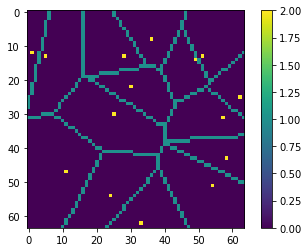

In [41]:
canvas = np.zeros((64,64))

for l in valid_lines:
    for p in l:
        canvas[p] = 1

for s in sites.tolist():
    canvas[tuple(s)] = 2
plot2D(canvas)

# Voronoi diagram testing

In [3]:
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d 
import matplotlib.pyplot as plt

In [43]:
def voronoi_finite_polygons_2d(vor, radius=None):
    """Reconstruct infinite Voronoi regions in a
    2D diagram to finite regions.
    Source:
    [https://stackoverflow.com/a/20678647/1595060](https://stackoverflow.com/a/20678647/1595060)
    """
    print("Running voronoi_finite_polygons_2d")
    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")
    new_regions = []
    new_vertices = vor.vertices.tolist()
    new_ridge_vertices = []
    vor_ridge_vertices = vor.ridge_vertices
    for p in vor_ridge_vertices:
        if all(i >= 0 for i in p):
            new_ridge_vertices.append(p)
#     print("===================")
#     print("Starting state: ")
#     print("new_regions: ")
#     print(new_regions)
#     print("new_vertices: ")
#     print(new_vertices)
    center = vor.points.mean(axis=0)
#     print("center: " + str(center))
    if radius is None:
        radius = vor.points.ptp().max()
#     print("radius: " + str(radius))
    # Construct a map containing all ridges for a
    # given point
#     print("====================")
    
#     print("====================")
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points,
                                  vor.ridge_vertices):
        all_ridges.setdefault(
            p1, []).append((p2, v1, v2))
        all_ridges.setdefault(
            p2, []).append((p1, v1, v2))
#     print("all_ridges: ")
#     print(all_ridges)
#     print("====================")

#     print("--------------------")
    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region): # p1 is a counter (0,1, etc), region is the region "name (label)" for the p1th point
#         print("++++++++++++++++++++")
#         print("Examining p1: " + str(p1) + ", region: " + str(region))
        vertices = vor.regions[region] # Returns the vertices that corresponds to the "region_th" region. Region starts at 1
#         print("Vertices for this region: " + str(vertices))
        if all(v >= 0 for v in vertices):
            # finite region
#             print("All v >= 0, finite region, append to new_regions!")
            new_regions.append(vertices)
#             print("new_regions: ")
#             print(new_regions)
#             print("Continue!")
            continue
        # reconstruct a non-finite region
#         print("ridges for p1: (" + str(p1) + ")")
        ridges = all_ridges[p1] # Get a list of all ridges surrounding that point [(p2, v1, v2)]
#         print(ridges)
        new_region = [v for v in vertices if v >= 0] # new_region contains all the finite vertices from std vor
#         print("New_region: contains all finite vertices for region " + str(region))
#         print(new_region)
        for p2, v1, v2 in ridges:
#             print("====================")
#             print("Current ridge: (p1, p2, v1, v2)")
#             print("(" + str(p1) + ", " + str(p2) + ", " + str(v1) + ", " + str(v2) + ")")
            if v2 < 0: # Why is this here? Just to flip order?
                v1, v2 = v2, v1
            if v1 >= 0:  # v1 is always the one that could be at infinity
                # finite ridge: already in the region
#                 print("Neither vertices are infinite!")
#                 print("Continue!")
                continue
#             print("Current ridge updated: (p1, p2, v1, v2)")
#             print("(" + str(p1) + ", " + str(p2) + ", " + str(v1) + ", " + str(v2) + ")")
            # Compute the missing endpoint of an
            # infinite ridge
            t = vor.points[p2] - \
                vor.points[p1]  # tangent
            t /= np.linalg.norm(t) # Normalize
            n = np.array([-t[1], t[0]])  # normal
            midpoint = vor.points[[p1, p2]]. \
                mean(axis=0)
            direction = np.sign(
                np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + \
                direction * radius
#             print("far_point: " + str(far_point)) 
            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())
#             print("Updated new_region and new_vertices:")
#             print("new_region: " + str(new_region))
#             print("new_vertices: " + str(new_vertices))
            
#             print("Appending new ridge_vertices: ")
            new_ridge_vertices.append([v2, len(new_vertices)-1])
#             print("new_ridge_vertices: ")
#             print(new_ridge_vertices)
#             print("====================")
        # Sort region counterclockwise.
        vs = np.asarray([new_vertices[v]
                         for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(
            vs[:, 1] - c[1], vs[:, 0] - c[0])
        new_region = np.array(new_region)[
            np.argsort(angles)]
#         print("sorted new_region: " + str(new_region))
        new_regions.append(new_region.tolist())
#         print("Updated new_regions: " + str(new_regions))
#         print("++++++++++++++++++++")
    
#     print("--------------------")
    return new_regions, np.asarray(new_vertices), new_ridge_vertices


def vertIdxToVal(vertices, ridge_vertices):
    '''
    Transforms the array of *indices* ridge_vertices into actual locations
    Input:
        vertices: Array containing the locations of all vertices
        ridge_Vertices: Array of indices (to vertices) of the vertices that make up the ith ridge
    Output:
        ridge_vertices_vals: 3D Array (n, 2, 2) of locations of the vertices that make up the n ridges
    '''
    ridge_vertices_val = []
    for idx_pair in ridge_vertices:
        ridge_vertices_val.append((vertices[idx_pair[0]].tolist(), vertices[idx_pair[1]].tolist()))
    unique_ridge_vertices_vals = np.unique(np.asarray(ridge_vertices_val), axis=0)
    
    return unique_ridge_vertices_vals

def drawLine(start, end):
    '''
    Implements Bresenham's line algorithm
    From http://www.roguebasin.com/index.php?title=Bresenham%27s_Line_Algorithm
    
    Input:
        - start: Tuple of coordinates for starting point (x,y)
        - end: Tuple of coordinates for end point (x,y)
    Output:
        - points: List of points that make up the line between the start and end points
    '''
    # Setup initial conditions
    x1, y1 = start
    x2, y2 = end
    dx = x2 - x1
    dy = y2 - y1
 
    # Determine how steep the line is
    is_steep = abs(dy) > abs(dx)
 
    # Rotate line
    if is_steep:
        x1, y1 = y1, x1
        x2, y2 = y2, x2
 
    # Swap start and end points if necessary and store swap state
    swapped = False
    if x1 > x2:
        x1, x2 = x2, x1
        y1, y2 = y2, y1
        swapped = True
 
    # Recalculate differentials
    dx = x2 - x1
    dy = y2 - y1
 
    # Calculate error
    error = int(dx / 2.0)
    ystep = 1 if y1 < y2 else -1
 
    # Iterate over bounding box generating points between start and end
    y = y1
    points = []
    for x in range(x1, x2 + 1):
        coord = (y, x) if is_steep else (x, y)
        points.append(coord)
        error -= abs(dy)
        if error < 0:
            y += ystep
            error += dx
 
    # Reverse the list if the coordinates were swapped
    if swapped:
        points.reverse()
    return points

def drawMultipleLines(ridgeVertices):
    '''
    Calls the drawLine method for each pair of vertices in the array ridgeVertices
    Input:
        - ridgeVertices: 3D array (n, 2, 2) where n is the number of ridges to draw,
                         the second dimension represents the two endpoints of the line, 
                         and the third dimension represents the x,y coordinates for a point
    Outpu:
        - lines: A list of lists, where each of the lists is the coordinates of the points
                 that make up each line
    
    '''
    
    lines = []
    for n in range(ridgeVertices.shape[0]):
        v1 = tuple(ridgeVertices[n][0])
        v2 = tuple(ridgeVertices[n][1])
        
        # Make the vertices integers instead of floats
        v1 = tuple(map(int, v1))
        v2 = tuple(map(int, v2))
        lines.append(drawLine(v1, v2))
    return lines
    

## Test segment filling algorithms

### Test skimage using two points

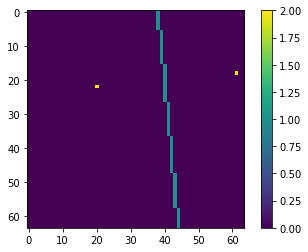

In [59]:
map_shape = (64,64)
canvas = np.zeros(map_shape)
p1 = (np.random.randint(0,map_shape[0]-1), np.random.randint(0,map_shape[1]-1))
p2 = (np.random.randint(0,map_shape[0]-1), np.random.randint(0,map_shape[1]-1))


midpoint, slope = midPoint_and_slope(p1, p2)
endpoints, raw_endpoints = findEndpoints(midpoint, slope, map_shape)
endp1 = endpoints[0]
endp2 = endpoints[1]

# Draw Bresenham's line: 
# Assume endpoints has two elements
# We need to reverse the order of the points for plotting purposes. See convention above

points = drawLine(endp1[::-1],endp2[::-1])
for i in points:
    canvas[i] = 1
canvas[p1[::-1]] = 2
canvas[p2[::-1]] = 2
plot2D(canvas)



In [60]:
endp1

(44, 63)

In [61]:
from skimage.draw import polygon_perimeter
canvas_scikit = np.zeros(map_shape, dtype=np.uint8)
rr, cc = polygon_perimeter([endp1[0], endp2[0]], [endp1[1], endp2[1]],shape=canvas_scikit.shape, clip=True)

IndexError: list index out of range

Results: Using only two points doesn't seem to work

### Test skimage using three points

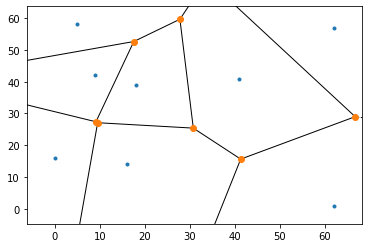

Running voronoi_finite_polygons_2d


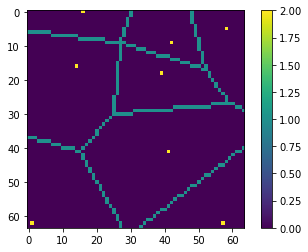

In [62]:
sites = np.random.randint(0, 63, (8,2))
vor = Voronoi(sites)
voronoi_plot_2d(vor)
plt.show()
new_regions, new_vertices, new_ridge_vertices = voronoi_finite_polygons_2d(vor, 10000)
ridge_verts = vertIdxToVal(new_vertices, new_ridge_vertices)
lines = drawMultipleLines(ridge_verts)

# Clip lines to map size
x_min = 0
x_max = 63
y_min = 0
y_max = 63
valid_lines = []
for line in lines:
    temp_line = []
    for i,p in enumerate(line):
        if (p[0] >= x_min and p[0] <= x_max) and (p[1] >= y_min and p[1] <= y_max):
            temp_line.append(p)
    valid_lines.append(temp_line)
    
# Draw on canvas
canvas = np.zeros((64,64))
for l in valid_lines:
    for p in l:
        canvas[p] = 1

for s in sites.tolist():
    canvas[tuple(s)] = 2
plot2D(canvas)

Region size: 349
Region size: 295
Region size: 1096
Region size: 525
Region size: 467
Region size: 797
Region size: 317
Region size: 250


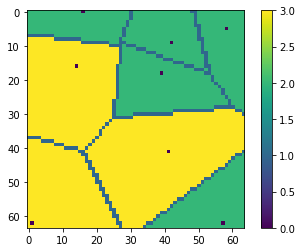

In [63]:
from skimage.draw import polygon_perimeter, polygon
canvas_scikit = np.zeros(map_shape, dtype=np.uint8)

# Color coding
GENS = 0 # Generators (points used to generate Voronoi diagram)
LINES = 1 # "Cutting lines"
COLL = 2 # A region is colored this value if it is "collectible" (area <= threshold)
NOTCOLL = 3 # A region is colored this value if it isn't "collectible" (area > threshold)
COLL_THRESH = 500 # Threshold to determine whether a region is collectible or not
    
for r in new_regions:
    vs = new_vertices[r,:]
    v_x = vs[:,0].tolist()
    v_y = vs[:,1].tolist()
    rr_fill, cc_fill = polygon(v_x, v_y,shape=canvas_scikit.shape)
    print("Region size: " + str(rr_fill.shape[0]))
    if rr_fill.shape[0] <= COLL_THRESH:
        canvas_scikit[rr_fill, cc_fill] = COLL
    else:
        canvas_scikit[rr_fill, cc_fill] = NOTCOLL
    rr, cc = polygon_perimeter(v_x, v_y,shape=canvas_scikit.shape, clip=False)
    canvas_scikit[rr, cc] = LINES
#     color+=1
    
for s in sites.tolist():
    canvas_scikit[tuple(s)] = GENS
    
plot2D(canvas_scikit)

In [64]:
def generatePlot(sites, map_shape, validateArea=True, validateLines=True):
    canvas = np.zeros(map_shape, dtype=np.uint8)
    
    # No sites
    if sites.shape[0] == 0:
        return canvas # Return empty canvas
    
    # One site
    elif sites.shape[0] == 1:
        # Plot generators
        for s in sites.tolist():
            canvas[tuple(s)] = GENS
            
    # Two sites
    elif sites.shape[0] == 2:
        
        # Calculate perpendicular bisector and get vertices at the boundary
        midpoint, slope = midPoint_and_slope(tuple(sites[0]), tuple(sites[1]))
        endpoints, raw_endpoints = findEndpoints(midpoint, slope, map_shape)
        endp1 = endpoints[0]
        endp2 = endpoints[1]

        # TODO: Add if statement to validate line
        # Draw Bresenham's line: 
        points = drawLine(endp1[::-1],endp2[::-1])
        for i in points:
            canvas[i] = LINES
            
        # Validate area
        if validateArea:
            temp_color1 = 4
            temp_color2 = 5
            area1 = 0
            area2 = 0
            
#             # Label and count two regions
#             for k in range(len(points)):
#                 i = points[k][0]
#                 for j in range(points[k][1]-1):
#                     canvas[i][j] = temp_color1
#                     area1 += 1
#                 for j in range(map_shape[0]-points[k][1]):
#                     canvas[i][-j-1] = temp_color2
#                     area2 += 1
                    
#             for r in range(map_shape[0]):
#                 color = temp_color1
#                 area_toggle = 0
#                 for c in range(map_shape[1]):
#                     if canvas[r,c] == LINES:
#                         color = temp_color2
#                         area_toggle = 1
#                         continue
#                     canvas[r,c] = color
#                     if area_toggle == 0:
#                         area1 += 1
#                     else:
#                         area2 += 1
                        
            for r in range(map_shape[0]):
                for c in range(map_shape[1]):
                    if canvas[r,c] == LINES:
                        continue
                    elif r > slope * c - (slope*midpoint[0] + midpoint[1]):
                        area1 += 1
                        canvas[r,c] = temp_color1
                    else:
                        area2 += 1
                        canvas[r,c] = temp_color2
                        
            # Validate region 1
#             if area1 <= COLL_THRESH:
#                 canvas[np.where(canvas == temp_color1)] = COLL
#             else:
#                 canvas[np.where(canvas == temp_color1)] = NOTCOLL
            
#             # Validate region 2
#             if area2 <= COLL_THRESH:
#                 canvas[np.where(canvas == temp_color2)] = COLL
#             else:
#                 canvas[np.where(canvas == temp_color2)] = NOTCOLL
                
        # Plot generators
        for s in sites.tolist():
            canvas[tuple(s[::-1])] = GENS
                
    else:
        vor = Voronoi(sites)
        new_regions, new_vertices, new_ridge_vertices = voronoi_finite_polygons_2d(vor, 10000)
        ridge_verts = vertIdxToVal(new_vertices, new_ridge_vertices)
        
        # Draw lines and optionally validate area
        for r in new_regions:
            vs = new_vertices[r,:]
            v_x = vs[:,0].tolist()
            v_y = vs[:,1].tolist()
            
            if validateArea:
                rr_fill, cc_fill = polygon(v_x, v_y,shape=canvas.shape)
                print("Region size: " + str(rr_fill.shape[0]))
                if rr_fill.shape[0] <= COLL_THRESH:
                    canvas[rr_fill, cc_fill] = COLL
                else:
                    canvas[rr_fill, cc_fill] = NOTCOLL
                    
            rr, cc = polygon_perimeter(v_x, v_y,shape=canvas.shape, clip=False)
            canvas[rr, cc] = LINES
    
        # Plot generators
        for s in sites.tolist():
            canvas[tuple(s)] = GENS
            
    return canvas

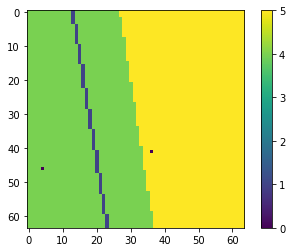

In [65]:
sites = np.random.randint(0, 63, (2,2))
map_shape = (64,64)
canvas = generatePlot(sites, map_shape, validateArea=True, validateLines=True)
plot2D(canvas)

In [66]:
sites

array([[ 4, 46],
       [36, 41]])

In [67]:
midpoint, slope = midPoint_and_slope(tuple(sites[0]), tuple(sites[1]))
endpoints, raw_endpoints = findEndpoints(midpoint, slope, map_shape)
endp1 = endpoints[0]
endp2 = endpoints[1]

In [68]:
midpoint

(20.0, 43.5)

In [69]:
slope

6.4

In [70]:
slope == np.inf

False

In [71]:
endp1

(23, 63)

In [72]:
endp2

(13, 0)

In [73]:
raw_endpoints

[(13.203125, 0), (63, 318.70000000000005), (23.046875, 63), (0, -84.5)]

In [382]:
def countArea2Gen(endp1, endp2, midpoint, slope, map_shape):
    temp_color1 = 4
    temp_color2 = 5
    area1 = 0
    area2 = 0
            
    canvas = np.zeros(map_shape)
    points = drawLine(endp1[::-1],endp2[::-1])
    
    
    # Vertical cutting line
    if slope == np.inf or slope == -np.inf:
        for r in range(map_shape[1]):
            for c in range(map_shape[0]):
                if c < int(midpoint[0]):
                    canvas[r,c] = temp_color1
                    area1 += 1
                elif c > int(midpoint[0]):
                    canvas[r,c] = temp_color2
                    area2 += 1
    
    # For any other line, use actual y value to determine area
    for r in range(map_shape[1]):
        for c in range(map_shape[0]):
            real_y = slope*(c - midpoint[0]) + midpoint[1]
            if r > real_y:
                canvas[r,c] = temp_color1
                area1 += 1
            else:
                canvas[r,c] = temp_color2
                area2 += 1
                
    # Plot lines
    for i in points:
        canvas[i] = LINES
    
    return canvas
    

In [383]:
map_shape = (64,64)

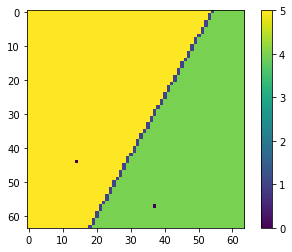

In [322]:
# sites = np.array([[14,30],[32,10]])
sites = np.random.randint(0, 63, (2,2))
midpoint, slope = midPoint_and_slope(tuple(sites[0]), tuple(sites[1]))
endpoints, raw_endpoints = findEndpoints(midpoint, slope, map_shape)
endp1 = endpoints[0]
endp2 = endpoints[1]
canvas = countArea2Gen(endp1, endp2, midpoint, slope, map_shape)
for s in sites.tolist():
    s = s[::-1]
    canvas[tuple(s)] = GENS
plot2D(canvas)

In [636]:
class Region:
    def __init__(self, area = 0, coll = False, vertices = []):
        self.area = area
        self.coll = coll
        self.vertices = vertices
    
current_regions = []

def generatePlot(sites, map_shape, validateArea=True, validateLines=True):
    canvas = np.zeros(map_shape, dtype=np.uint8)
    
    # Define functions for two cases: 2 generators, or more than 2 generators

    def twoGenerators():
        midpoint, slope = midPoint_and_slope(tuple(sites[0]), tuple(sites[1]))
        endpoints, raw_endpoints = findEndpoints(midpoint, slope, map_shape)
        endp1 = endpoints[0]
        endp2 = endpoints[1]
    
        temp_color1 = 4
        temp_color2 = 5
        area1 = 0
        area2 = 0
            
#         canvas = np.zeros(map_shape)
        points = drawLine(endp1[::-1],endp2[::-1])
    
    
        # Vertical cutting line
        if slope == np.inf or slope == -np.inf:
            for r in range(map_shape[1]):
                for c in range(map_shape[0]):
                    if c < int(midpoint[0]):
                        canvas[r,c] = temp_color1
                        area1 += 1
                    elif c > int(midpoint[0]):
                        canvas[r,c] = temp_color2
                        area2 += 1
    
        # For any other line, use actual y value to determine area
        for r in range(map_shape[1]):
            for c in range(map_shape[0]):
                real_y = slope*(c - midpoint[0]) + midpoint[1]
                if r > real_y:
                    canvas[r,c] = temp_color1
                    area1 += 1
                else:
                    canvas[r,c] = temp_color2
                    area2 += 1
                    
        # Add regions to region list
        temp_region = Region(area1)
        # Assign actual colors to the areas (validate areas)
        region1 = np.where(canvas == temp_color1)
        if region1[0].shape[0] <= COLL_THRESH:
            canvas[region1] = COLL
            temp_region.coll = True
        else:
            canvas[region1] = NOTCOLL
            temp_region.coll = False
        current_regions.append(temp_region)
        
        temp_region = Region(area2)
        region2 = np.where(canvas == temp_color2)
        if region2[0].shape[0] <= COLL_THRESH:
            canvas[region2] = COLL
            temp_region.coll = True
        else:
            canvas[region2] = NOTCOLL
            temp_region.coll = False
        current_regions.append(temp_region)
        
                
        # Plot lines
        for i in points:
            canvas[i] = LINES
    
#         return canvas

    def moreThanTwoGenerators():
        vor = Voronoi(sites)
        print("Regular Regions: ")
        print(vor.regions)
        print(len(vor.regions))
        new_regions, new_vertices, new_ridge_vertices = voronoi_finite_polygons_2d(vor, 10000)
        print("New Regions: ")
        print(new_regions)
        print(len(new_regions))
        ridge_verts = vertIdxToVal(new_vertices, new_ridge_vertices)
        
        # Draw lines and optionally validate area
        for r in new_regions:
            vs = new_vertices[r,:]
            v_x = vs[:,0].tolist()
            v_y = vs[:,1].tolist()
            
            rr_fill, cc_fill = polygon(v_x, v_y,shape=canvas.shape)
            temp_region = Region(rr_fill.shape[0])
            print("Region size: " + str(rr_fill.shape[0]))
            if rr_fill.shape[0] <= COLL_THRESH:
                canvas[rr_fill, cc_fill] = COLL
                temp_region.coll = True
            else:
                canvas[rr_fill, cc_fill] = NOTCOLL
                temp_region.coll = False
                    
            current_regions.append(temp_region)
            rr, cc = polygon_perimeter(v_x, v_y,shape=canvas.shape, clip=False)
            canvas[rr, cc] = LINES
#         return canvas
    
    # Do appropriate action based on number of generators

    # No sites
    if sites.shape[0] == 0:
        return canvas # Return empty canvas
    
    # One site
    elif sites.shape[0] == 1:
        # Plot generators
        for s in sites.tolist():
            canvas[tuple(s)] = GENS
    
    # Two sites
    elif sites.shape[0] == 2:
        twoGenerators()
    
    # More than two sites
    else:
        moreThanTwoGenerators()
    
    print("current_region")
    for r in current_regions:
        print(r.coll)
    return canvas

Regular Regions: 
[[], [1, -1, 0], [4, 2, 3], [4, 1, -1, 2], [3, 0, -1, 2], [4, 1, 0, 3]]
6
Running voronoi_finite_polygons_2d
New Regions: 
[[0, 3, 2, 6, 5], [4, 1, 0, 3], [7, 8, 2, 4, 1], [10, 1, 0, 9], [4, 2, 3]]
5
Region size: 1207
Region size: 761
Region size: 327
Region size: 1065
Region size: 736
current_region
True
False
True
False
True
False
True
True
True
False
True
True
True
True
False
True
False
True
True
False
True


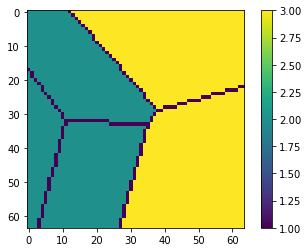

In [641]:
COLL_THRESH = 1000
sites = np.random.randint(0, 63, (5,2))
map_shape = (64,64)
canvas = generatePlot(sites, map_shape, validateArea=True, validateLines=True)
plot2D(canvas)

## Try out interpolation

In [84]:
from scipy.interpolate import interp1d
m = interp1d([-1,1],[0,63])

In [102]:
int(m(0))

31

In [1]:
import numpy as np

In [18]:
g = [np.array([1.0, 2.0]), np.array([3.0, 4.0])]

In [19]:
g

[array([1., 2.]), array([3., 4.])]

In [20]:
g[0][::-1]

array([2., 1.])

In [21]:
c = np.zeros((64, 64))

In [22]:
i = tuple(g[0][::-1])

In [25]:
i

(2.0, 1.0)

In [26]:
tuple(map(int, i))

(2, 1)

In [23]:
c[i] = 1

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [17]:
c

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])